In [105]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import polars as pl
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns
import os
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, learning_curve, RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, cross_val_score
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.cluster import KMeans

from utils.merge_tools import merge_n_case_ids

## Data Preprocessing

In [106]:
data_dir = 'D:/Kaggle_Credit_Risk_Predictions/new_aggs/new_aggs'
base_file = 'D:/Kaggle_Credit_Risk_Predictions/parquet_files/train/train_base.parquet'

In [107]:
def merge_n_case_ids(
    n_ids: int = 1000,
    data_dir: str = 'D:/Kaggle_Credit_Risk_Predictions/new_aggs/new_aggs',
    path_to_base: str = 'D:/Kaggle_Credit_Risk_Predictions/parquet_files/train/train_base.parquet',
    use_0: bool = True,
    as_pandas: bool = True,
    random_state: int = 28
) -> pl.DataFrame | pd.DataFrame:
    '''
    Function to merge selected case_id from parquet files, returns subset case_id from the merged dataset.

    Parameters
    ----------
    n_ids : Number of case_ids to sample initially and return (int)
    data_dir : Path to processed parquet files directory (str)
    path_to_base : Path to base file (str)
    use_0 : Use num_group1 == 0 (bool)
    as_pandas : Return as pandas DataFrame
    random_seed : Random seed (int)
    '''
    # Read the base dataframe and sample case_ids
    if as_pandas:
        base_df = pd.read_parquet(path_to_base)
        case_ids = base_df['case_id'].sample(n=n_ids, replace=False, random_state=random_state).tolist()
    else:
        base_df = pl.read_parquet(path_to_base)
        case_ids = base_df['case_id'].sample(n=n_ids, replace=False, seed=random_state).to_list()

    # Define the file pattern for fetching files
    file_pattern = '*grouped_0.parquet' if use_0 else '*grouped_rest.parquet'
    file_paths = glob(data_dir + '/' + file_pattern)

    # Initialize the merged DataFrame filtering the base DataFrame
    if as_pandas:
        df = base_df[base_df['case_id'].isin(case_ids)]
    else:
        df = base_df.filter(pl.col('case_id').is_in(case_ids))

    # Merge DataFrames with only the selected case_ids
    for path in file_paths:
        if as_pandas:
            temp = pd.read_parquet(path)
            temp = temp[temp['case_id'].isin(case_ids)]
            df = pd.merge(df, temp, on='case_id', how='outer')
        else:
            temp = pl.read_parquet(path)
            temp = temp.filter(pl.col('case_id').is_in(case_ids))
            df = df.join(temp, on='case_id', how='outer')

    # Convert to pandas if required and using Polars
    if as_pandas and isinstance(df, pl.DataFrame):
        df = df.to_pandas()

    return df

In [108]:
df = merge_n_case_ids(
    n_ids=1000,
    data_dir='D:/Kaggle_Credit_Risk_Predictions/new_aggs/new_aggs',
    path_to_base='D:/Kaggle_Credit_Risk_Predictions/parquet_files/train/train_base.parquet',
    use_0=True,
    as_pandas=True,
    random_state=28  
)

In [109]:
#case_ids_list = list(df['case_id'])

df_rest = merge_n_case_ids(
    n_ids=1000,
    data_dir=data_dir,
    path_to_base=base_file,
    use_0=False,
    as_pandas=True,
    random_state=28
)

In [110]:
df = pd.merge(df, df_rest, how='left', on='case_id', suffixes=("", "_r"))

In [111]:
df.head()

,case_id,date_decision,MONTH,WEEK_NUM,target,actualdpd_943P_min,annuity_853A_min,byoccupationinc_3656910L_min,childnum_21L_min,credacc_actualbalance_314A_min,...,employername_160M_binary_7_r,employername_160M_binary_8_r,employername_160M_binary_9_r,employername_160M_binary_10_r,employername_160M_binary_11_r,employername_160M_binary_12_r,employername_160M_binary_13_r,employername_160M_binary_14_r,employername_160M_binary_15_r,employername_160M_binary_16_r
0,4927,2019-02-15,201902,6,1,NaN,NaN,NaN,NaN,NaN,...,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0
1,7449,2019-03-11,201903,9,0,NaN,NaN,NaN,NaN,NaN,...,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
2,7786,2019-03-12,201903,10,0,0.0,1952.8,NaN,NaN,NaN,...,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0
3,8275,2019-03-16,201903,10,0,NaN,NaN,NaN,NaN,NaN,...,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0
4,10950,2019-04-09,201904,14,0,NaN,NaN,NaN,NaN,NaN,...,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0


In [112]:
df.dtypes.value_counts()

float64    2495
int8         99
object       30
uint32        8
int64         7
int32         2
Name: count, dtype: int64

In [113]:
df.shape

(1000, 2641)

In [114]:
# Drop empty columns
df = df.dropna(how='all', axis=1)

In [115]:
df.shape

(1000, 2524)

In [116]:
# Extract date info from base
df['date_decision'] = pd.to_datetime(df['date_decision'])
df['dec_day'] = df['date_decision'].dt.day
df['dec_month'] = df['date_decision'].dt.month
df['dec_year'] = df['date_decision'].dt.year

# Drop redundant information
df = df.drop(columns=[
    'MONTH', 'MONTH_r', 'WEEK_NUM', 'WEEK_NUM_r', 
    'date_decision', 'date_decision_r','case_id',
    'target_r'
])

In [117]:
# Get bool cols with na
na_bool_cols = df.select_dtypes(include=['O']).columns

# Remove redundant
na_bool_cols = [ col for col in na_bool_cols if col.__contains__('min') ]
df = df.drop(columns=na_bool_cols)

In [118]:
# Create null flags
na_cols = df.columns[df.isna().any()].to_list()
isna_cols = [ col + '_isna' for col in na_cols ]
na_df = df[na_cols].isna()
na_df.columns = isna_cols

df = pd.concat([df, na_df], axis=1)

# Free memory
del na_df

In [119]:
# Drop columns below treshold
df = df.dropna(thresh=len(df)//10, axis=1)

## Train Test Split

In [120]:
X = df.drop(columns='target')
y = df[['target']]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=28)

In [121]:
X_train.dtypes.value_counts()

bool       2354
float64    1595
int8         99
object        8
uint32        8
int32         5
Name: count, dtype: int64

In [122]:
# Fill na from X_train median and mode
X_train[X_train.select_dtypes(exclude=['O', 'bool']).columns] = X_train.select_dtypes(exclude=['O', 'bool']).fillna(X_train.median())
X_test[X_test.select_dtypes(exclude=['O', 'bool']).columns] = X_test.select_dtypes(exclude=['O', 'bool']).fillna(X_train.median())
X_train[X_train.select_dtypes(include=['O', 'bool']).columns] = X_train.select_dtypes(include=['O', 'bool']).fillna(X_train.mode())
X_test[X_test.select_dtypes(include=['O', 'bool']).columns] = X_test.select_dtypes(include=['O', 'bool']).fillna(X_train.mode())

In [123]:
remain_na_cols = X_train.columns[X_train.isna().any()].to_list()
for col in remain_na_cols:
    X_train[col] = X_train[col].fillna(X_train[col].mode()[0])
    X_test[col] = X_test[col].fillna(X_train[col].mode()[0])

## Handle imbalanced data

In [124]:
sm = SMOTE(random_state=28)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

## Experiment with Clustering

## Try Elbow method to know the number of clusters to use

In [125]:
# Create an imputer object using the mean as replacement
imputer = SimpleImputer(strategy='mean')

# Impute missing values
X_imputed = imputer.fit_transform(X)  # Assuming X is your dataset

# Now apply KMeans
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X_imputed)

Clustering can be used to create new features that might help in improving the classification performance. Here, clustered the whole dataset and used the cluster labels as a new feature.

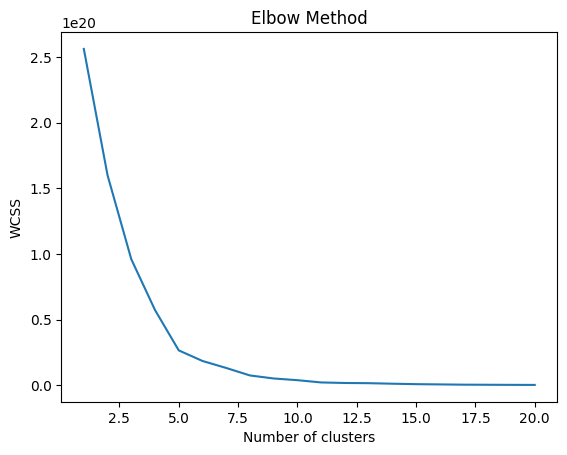

In [149]:
# Create an imputer object using the mean as replacement
imputer = SimpleImputer(strategy='mean')

# Impute missing values
X_imputed = imputer.fit_transform(X) 

wcss = []  
for i in range(1, 21): 
    kmeans = KMeans(n_clusters=i, random_state=28)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 21), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

Within-cluster sum of squares (WCSS) as a function of the number of clusters:

The curve is steep initially and then begins to flatten, indicating diminishing gains in variance reduction with the addition of more clusters.
The "elbow" point, where the rate of decrease sharply shifts, is typically chosen as the optimal number of clusters. The graph shows a potential elbow around 4 to 5 clusters.

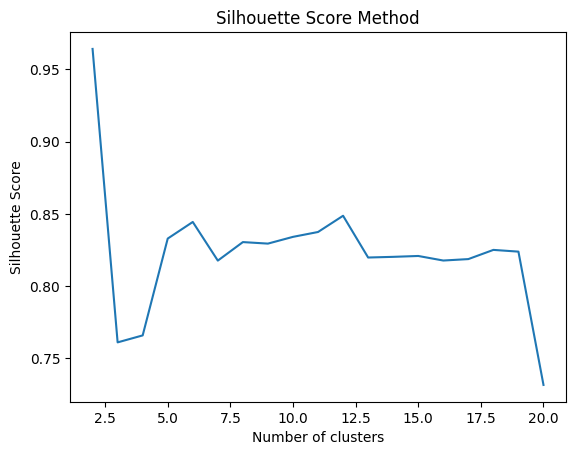

In [127]:
from sklearn.metrics import silhouette_score

silhouette_scores = []
for i in range(2, 21):
    kmeans = KMeans(n_clusters=i, random_state=28)
    kmeans.fit(X)
    score = silhouette_score(X, kmeans.labels_)
    silhouette_scores.append(score)

plt.plot(range(2, 21), silhouette_scores)
plt.title('Silhouette Score Method')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.show()


The Silhouette Score graph indicates how well each data point fits within its cluster. A higher score signifies a better fit. The score remains relatively steady from around 5 to 15 clusters with minor fluctuations, but overall above 0.80, which is still reasonably good.

## Feature Engineering with Clusters

In [128]:
kmeans = KMeans(n_clusters=5, random_state=28)
kmeans.fit(X_train_res)
X_train_res['cluster'] = kmeans.labels_
X_test['cluster'] = kmeans.predict(X_test)

## Random Forest Model Training and Evaluation

Train the model using the preprocessed and resampled data. Use the cluster labels as new features in the dataset. This step involves training a clustering algorithm (like KMeans) on the dataset and using the resulting labels as new columns in the dataset.

In [129]:
clf = RandomForestClassifier(random_state=28)
clf.fit(X_train_res, y_train_res)
y_pred = clf.predict(X_test)

# Evaluation
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      1.00      0.98       191
           1       0.00      0.00      0.00         9

    accuracy                           0.95       200
   macro avg       0.48      0.50      0.49       200
weighted avg       0.91      0.95      0.93       200

Confusion Matrix:
[[191   0]
 [  9   0]]
Accuracy: 0.955


## Plot Confusion Matrix

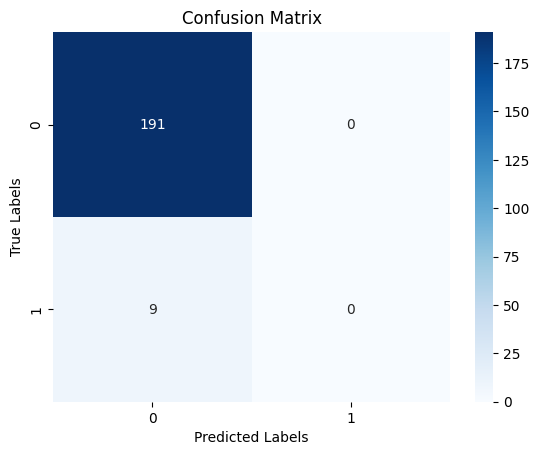

In [130]:
conf_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

## Feature Importance

In [143]:
# Creating and fitting the model
rfc = RandomForestClassifier(n_estimators=100, random_state=42)
rfc.fit(X_train, y_train)

# Get feature importances
feature_importances = rfc.feature_importances_

In [144]:
# Get feature names
features = X.columns

# Create a DataFrame for visualization
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})

# Sort features by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Select the top 30 features
top_features = feature_importance_df.head(30)['Feature'].tolist()


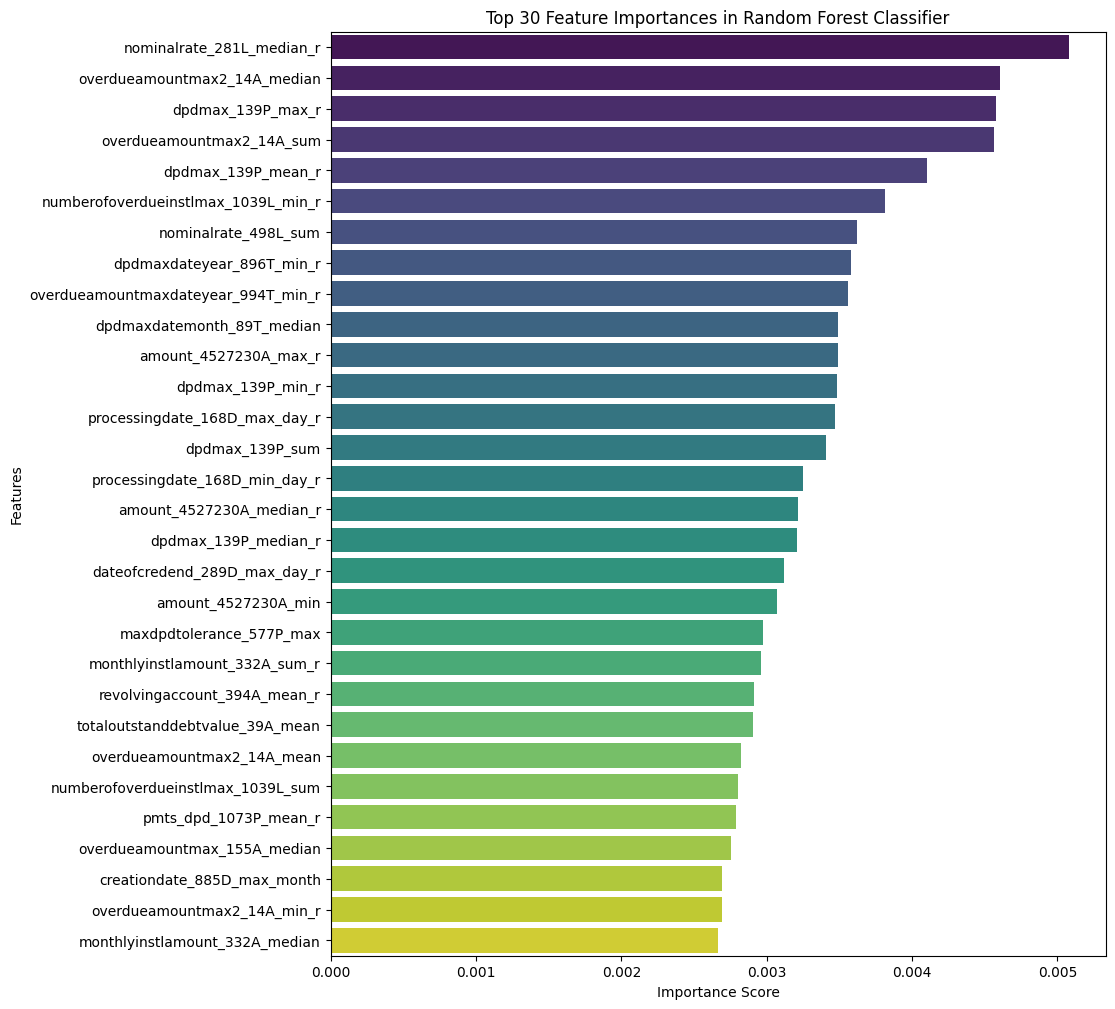

In [146]:
top_30_features_df = feature_importance_df.head(30)

# Plotting
plt.figure(figsize=(10, 12))
sns.barplot(x='Importance', y='Feature', data=top_30_features_df, palette='viridis')

plt.title('Top 30 Feature Importances in Random Forest Classifier')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()


In [148]:
# Reduce training and test sets to top 30 features
X_train_reduced = X_train[top_features]
X_test_reduced = X_test[top_features]

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_reduced, y_train)

# Re-fit the Random Forest model
rfc_smote = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rfc_smote.fit(X_train_smote, y_train_smote)

# Prediction and Evaluation
y_pred_smote = rfc_smote.predict(X_test_reduced)
print("Accuracy:", accuracy_score(y_test, y_pred_smote))
print("Classification Report:\n", classification_report(y_test, y_pred_smote))


Accuracy: 0.905
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.95      0.95       191
           1       0.00      0.00      0.00         9

    accuracy                           0.91       200
   macro avg       0.48      0.47      0.48       200
weighted avg       0.91      0.91      0.91       200

